# Ford Go Bike 2018
|   * * * * * * * * * *   | **Udacity**         | 
| -------------           |:-------------:      |
| **Nanodegree:**         | *Data Analyst*    | 
| **Student:**            | *Theresa Kocher*    |
| **Date:**               | *4th May 2019*|


## Investigation Overview

> In this investigation, we will have a look at the different cities where the bike rent service is located. Then, we will investigate if there are differences between the users in those cities.

## Dataset Overview

> The data consists of the **Ford GoBike**'s trip data that is for public use. For this investigation only the acquired data of the year 2018 were analysed.

In [145]:
import glob, os
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from IPython.core.display import Image, display
from mpl_toolkits.basemap import Basemap
from PIL import Image
import pylab as pl

%matplotlib inline

In [146]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

We will treat the following **leading questions** in this presentation:

1. Are there more busier rent stations than others?

2. In which cities were the Ford GoBikes rent in 2018?

3. Are there different kind of users in different cities?

First of all, here are the prepared data. The data is split into 3 tables.

In the following, the first 5 lines of each table are shown:

#### Rent activity dataframe

In [147]:
conn = sqlite3.connect("data/cleaned/rent.db")
rent_clean = pd.read_sql_query("select * from rent;", conn)
rent_clean.head()

rent_id  bike_id  bike_share_for_all_trip  duration_sec  start_station_id  \
0        0     1035                        0           598               284   
1        1     1673                        0           943                 6   
2        2     3498                        0         18587                93   
3        3     3129                        0         18558                93   
4        4     1839                        1           885               308   

                   start_time  end_station_id                    end_time  \
0  2018-02-28 23:59:47.097000             114  2018-03-01 00:09:45.187000   
1  2018-02-28 23:21:16.495000             324  2018-02-28 23:36:59.974000   
2  2018-02-28 18:20:55.190000              15  2018-02-28 23:30:42.925000   
3  2018-02-28 18:20:53.621000              15  2018-02-28 23:30:12.450000   
4  2018-02-28 23:15:12.858000             297  2018-02-28 23:29:58.608000   

   year  month  hour  
0  2018      2    23  
1  2018      2    23  
2  2018      2    18  
3  2018      2    18  
4  2018      2    23

#### User information (per rent activity)

In [148]:
conn = sqlite3.connect("data/cleaned/member.db")
member_clean = pd.read_sql_query("select * from member;", conn)
member_clean.head()

rent_id member_gender  member_birth_year   user_type   age
0        0          Male             1988.0  Subscriber  30.0
1        1          Male             1987.0    Customer  31.0
2        2        Female             1986.0    Customer  32.0
3        3          Male             1981.0    Customer  37.0
4        4        Female             1976.0  Subscriber  42.0

#### Rent station dataframe

In [149]:
conn = sqlite3.connect("data/cleaned/station.db")
station_clean = pd.read_sql_query("select * from station;", conn)
station_clean.head()

id   latitude   longitude  \
0  284.0  37.784872 -122.400876   
1    6.0  37.804770 -122.403234   
2   93.0  37.770407 -122.391198   
3  308.0  37.336802 -121.894090   
4  312.0  37.329732 -121.901782   

                                                name  
0  Yerba Buena Center for the Arts (Howard St at ...  
1                      The Embarcadero at Sansome St  
2                       4th St at Mission Bay Blvd S  
3                                   San Pedro Square  
4                           San Jose Diridon Station

In [150]:
# type conversions that got lost with ex- and import
rent_clean['bike_share_for_all_trip'] = rent_clean['bike_share_for_all_trip'].astype(bool)
rent_clean['end_time'] = pd.to_datetime(rent_clean['end_time'])
rent_clean['start_time'] = pd.to_datetime(rent_clean['start_time'])
rent_clean['start_station_id'] = rent_clean['start_station_id'].astype(int)
rent_clean['end_station_id'] = rent_clean['end_station_id'].astype(int)

## 4. Analyze and Visualize

### Univariate Explorations

In [151]:
# preparing data for amount of rents over time
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['date'] = rent_clean['start_time'].dt.date

rent_timeseries = pd.DataFrame(amount_of_rent.groupby('date')['amount'].sum())

In [152]:
# new feature 'amount' into station_clean
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['hour'] = rent_clean['start_time'].dt.hour
amount_of_rent['month'] = rent_clean['start_time'].dt.month

#print(hourly_amount['amount'].min(), hourly_amount['amount'].max())

## Question 1:  Are there more busier rent stations than others?

How busy are those rent stations? Where are the busiest rent stations located?

Preparing: Feature development

- add new feature 'amount' to station dataframe (the amount of rents in that station in year 2018).

In [153]:
# preparing rush on stations
rush_df = rent_clean.copy()
rush_df['amount'] = 1

station_rush_start = pd.DataFrame(rush_df.groupby('start_station_id')['amount'].sum())
station_rush_end = pd.DataFrame(rush_df.groupby('end_station_id')['amount'].sum())
print('amount start stations: ', station_rush_start.shape[0])
print('amount end stations: ', station_rush_end.shape[0])

station_rush_end.index.names = ['start_station_id']

rush = station_rush_start # .append(pd.DataFrame(station_rush_end))

print('BEFORE merging start and end ids: ', rush.shape)

for i, row in pd.DataFrame(station_rush_end).iterrows():
    if i in list(rush.index):
        rush.loc[i, 'amount'] += row['amount']
    else:
        rush = rush.append(row)
        
print('AFTER merging start and end ids: ', rush.shape)

amount start stations:  331
amount end stations:  331
BEFORE merging start and end ids:  (331, 1)
AFTER merging start and end ids:  (331, 1)


Before and after merging start and end stations, there are still 331 stations. This means, all stations are used as start and end stations.

In [154]:
# copy the amount of stations (in rush df) to a full station data frame
rush_stations = station_clean.copy()
rush_stations['amount'] = 0

for i, row in rush_stations.iterrows():
    station_id = row['id']
    if station_id in list(rush.index.values):
        amount = rush['amount'][station_id]
        rush_stations.loc[i, 'amount'] = amount

In [155]:
# converting data type to int
rush_stations['id'] = rush_stations['id'].astype(int)

Stations dataframe with new feature `amount`

In [156]:
rush_stations.head()

id   latitude   longitude  \
0  284  37.784872 -122.400876   
1    6  37.804770 -122.403234   
2   93  37.770407 -122.391198   
3  308  37.336802 -121.894090   
4  312  37.329732 -121.901782   

                                                name  amount  
0  Yerba Buena Center for the Arts (Howard St at ...   22990  
1                      The Embarcadero at Sansome St   72612  
2                       4th St at Mission Bay Blvd S   37363  
3                                   San Pedro Square    6053  
4                           San Jose Diridon Station   11588

#### The 40 busiest rent station meassured by the amount of rent/year

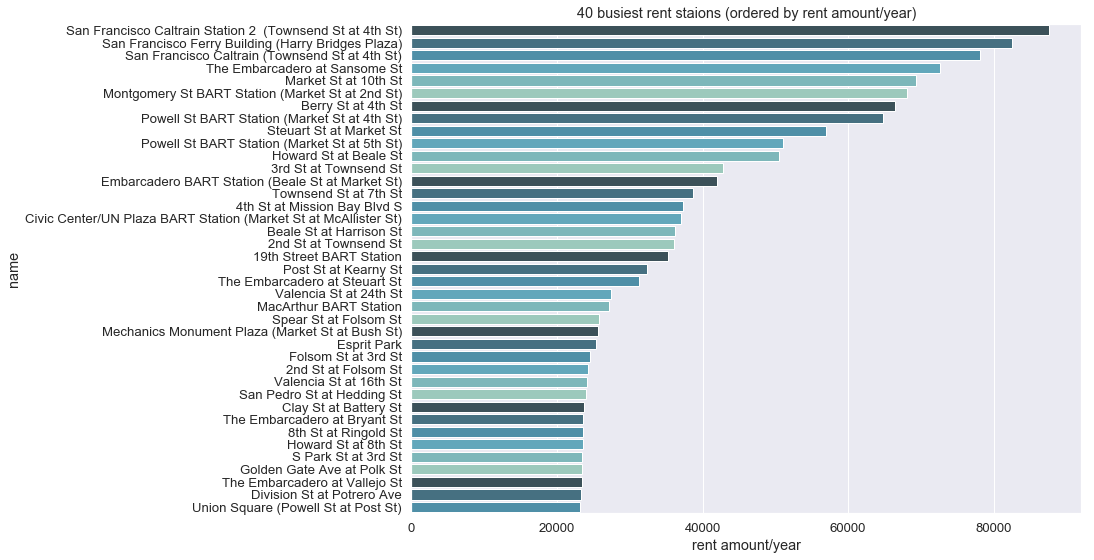

In [157]:
#preparing data
result = rush_stations.groupby(["name"])['amount'].aggregate(np.median).reset_index().sort_values('amount')

# show only left 40 bussyiest stations
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax = sns.barplot(x='amount', y="name", data=rush_stations, order=result['name'].iloc[:308:-1], palette=sns.color_palette("GnBu_d"));
ax.set_xlabel('rent amount/year');
plt.title('40 busiest rent staions (ordered by rent amount/year)');

In the above visualization, we can see that the station with the name *San FranciscoCaltrain Station 2 (Townsened St at 4th St)* is the station with the most rents in year 2018.

In total, there are about 10 to 20 more busier stations than others. All other stations are less busy and had more or less the same amount of rents in the year 2018 (about 20000 rents/year). The rents amount per station decreases when ordering the station by its rents amount. After ordering, it is almost logarithmically distributed.

## Question 2: In which cities were the Ford GoBikes rent in 2018?

Where are those rent stations located? Are all in one city or in several?

#### Location of stations (and their amount of rents/year)

In [158]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

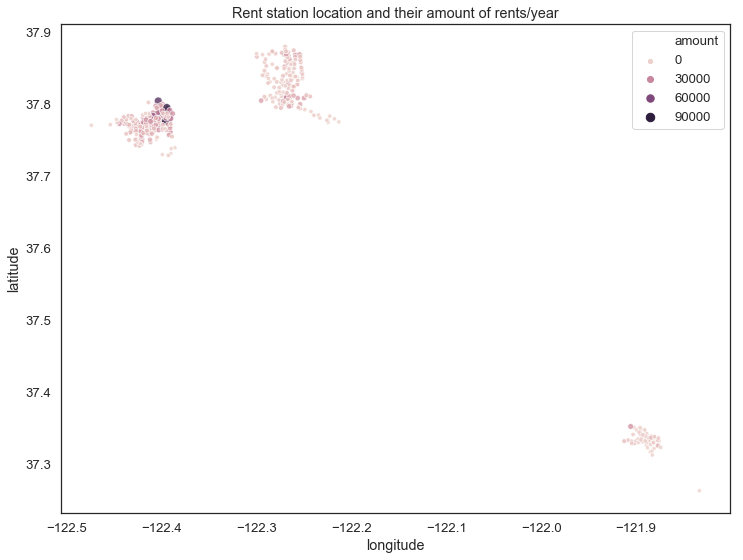

In [159]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="amount", size="amount",alpha=.8,
                      data=rush_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their amount of rents/year");

In [160]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

Let's plot these stations into a map...

In [161]:
# Extract the data we're interested in
lat = rush_stations['latitude'].values
lon = rush_stations['longitude'].values
amount = rush_stations['amount'].values
#area = cities['area_total_km2'].values


In [162]:
print('latitude range:', rush_stations['latitude'].min(), rush_stations['latitude'].max())
print('longitude range: ',rush_stations['longitude'].min(), rush_stations['longitude'].max())

print('latitude mean:', rush_stations['latitude'].mean())
print('longitude mean: ',rush_stations['longitude'].mean())


mean_latitude = rush_stations['latitude'].mean()
mean_longitude = rush_stations['longitude'].mean()
diff_latitude = rush_stations['latitude'].max() - rush_stations['latitude'].min()
diff_longitude =  rush_stations['longitude'].max() - rush_stations['longitude'].min()

print(mean_latitude, mean_longitude)
print(diff_latitude, diff_longitude)

latitude range: 37.26331 37.88022244590679
longitude range:  -122.473658 -121.83333200000001
latitude mean: 37.73065393097607
longitude mean:  -122.27529277694882
37.73065393097607 -122.27529277694882
0.6169124459067916 0.6403259999999875


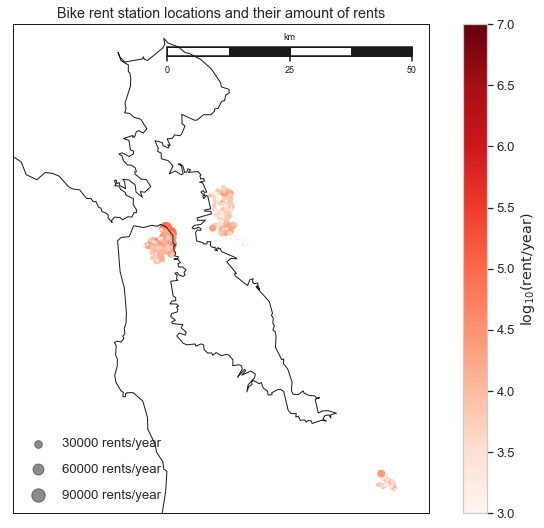

In [163]:
# 1. Draw the map background
fig = plt.figure(figsize=(12, 9))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=mean_latitude, lon_0=mean_longitude,
            width=0.085E6, height=0.1E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=mean_longitude+0.16, lat=mean_latitude+0.4, lon0=mean_longitude, lat0=mean_latitude, length=50, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

When we plot the station locations into a map, we see that there are three main parts (clusters), where the stations are located. It seems that the rent service has stations in three different cities. Let's try to find out, where the center of those 3 station clusters are. So that we can name them by their city name in an additional feature.

###  Cluster the 3 regions of rent stations

Use k-means algorithm from:  https://mubaris.com/posts/kmeans-clustering/

In [164]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


#### Rent station's location

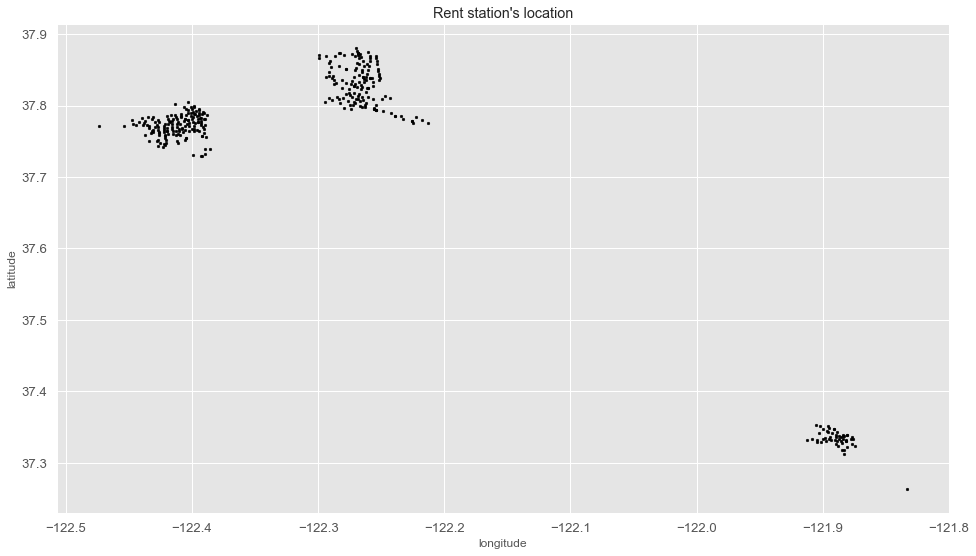

In [165]:
# Getting the values and plotting it
f1 = rush_stations['latitude'].values
f2 = rush_stations['longitude'].values
X = np.array(list(zip(f1, f2)))
plt.scatter(f2, f1, c='black', s=7);
plt.title("Rent station's location");
plt.xlabel('longitude');
plt.ylabel('latitude');

In [166]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


In [167]:
# Number of clusters
k = 3
# X coordinates of random centroids
C_x = np.array([37.4, 37.7, 37.9])
# Y coordinates of random centroids
C_y = np.array([-122.0, -122.4, -122.2])
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)


[[  37.4 -122. ]
 [  37.7 -122.4]
 [  37.9 -122.2]]


#### Rent stations location and the initial cluster center for k-means clustering

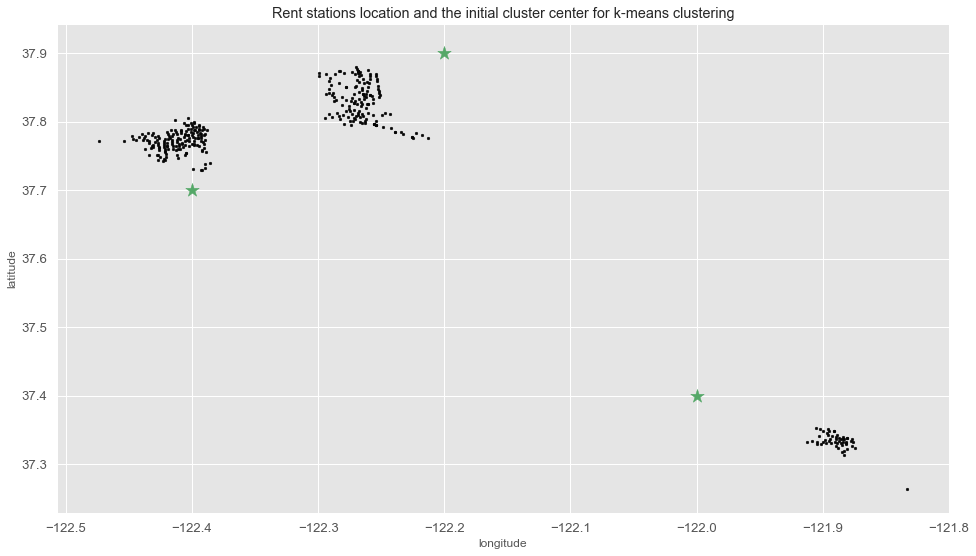

In [168]:
# Plotting along with the Centroids
plt.scatter(f2, f1, c='#050505', s=7)
plt.scatter(C_y, C_x, marker='*', s=200, c='g')
plt.title('Rent stations location and the initial cluster center for k-means clustering');
plt.xlabel('longitude');
plt.ylabel('latitude');

In [169]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)



#### Rent stations location and the new cluster centers after k-means

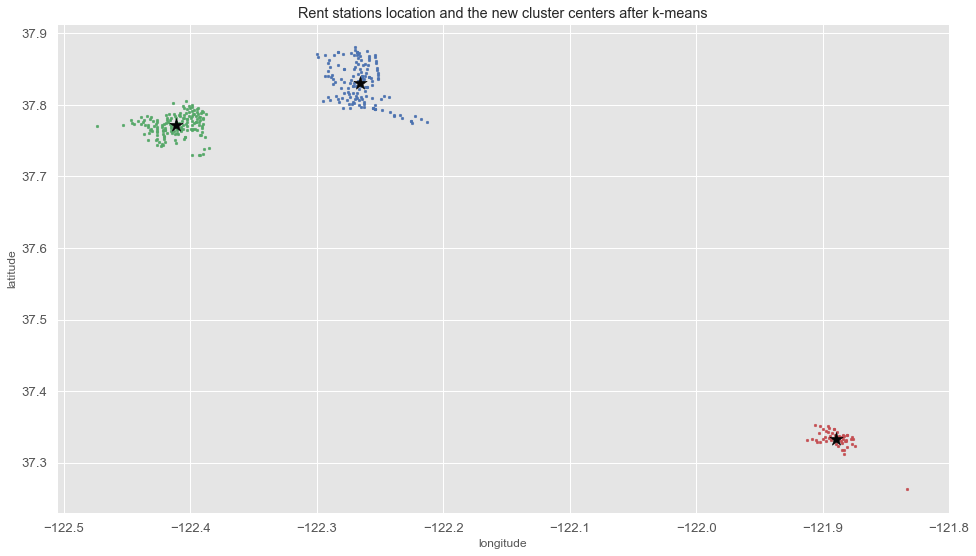

In [170]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 1], points[:, 0], s=7, c=colors[i])
ax.scatter(C[:, 1], C[:, 0], marker='*', s=200, c='#050505');
plt.title('Rent stations location and the new cluster centers after k-means');
plt.xlabel('longitude');
plt.ylabel('latitude');

In [171]:
C

array([[  37.333435, -121.88909 ],
       [  37.771667, -122.411606],
       [  37.830585, -122.26604 ]], dtype=float32)

There are three city centers found. When viewing the locations on the map, I can identify the following cities for the found cluster centers: **San Jose**, **San Francisco**, **East Bay**.

#### New feature: Cluster ID

Add the feature `cluster_id`, that was found with the *nearest-neighbour* algorithm above into the **station dataframe**.

In [172]:
clustered_stations = pd.DataFrame()
clustered_stations['latitude'] = pd.Series(X[:,0])
clustered_stations['longitude'] = pd.Series(X[:,1])
clustered_stations['cluster_id'] = pd.Series(clusters).astype(int)
clustered_stations.shape

(358, 3)

In [173]:
clustered_stations.head()

latitude   longitude  cluster_id
0  37.784872 -122.400876           1
1  37.804770 -122.403234           1
2  37.770407 -122.391198           1
3  37.336802 -121.894090           0
4  37.329732 -121.901782           0

In [174]:
# new feature
station_clean['cluster_id'] = clustered_stations['cluster_id']
station_clean['cluster_id'].value_counts()

1    160
2    145
0     53
Name: cluster_id, dtype: int64

In [175]:
clustered_stations['cluster_id'] = clustered_stations['cluster_id'].replace({0: 'San_Jose', 1: 'San_Francisco', 2: 'East_Bay'})

Now, we can use these classified clusters to label the rent stations in our dataframe with city/cluster labels...

In [176]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

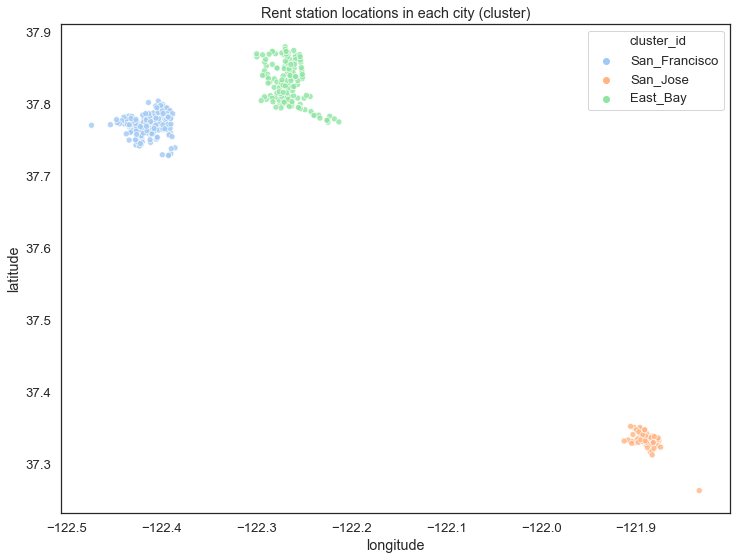

In [177]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="cluster_id", alpha=.8,
                      data=clustered_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station locations in each city (cluster)");

Here the rent stations are colored attributed to its city.

In the following, maps of the 3 cities **San Jose**, **San Francisco**, **East Bay** are shown. We can see the distributed locations of the rent stations in each city and their different amount of rents/year.

#### Bike rent stations in San Francisco

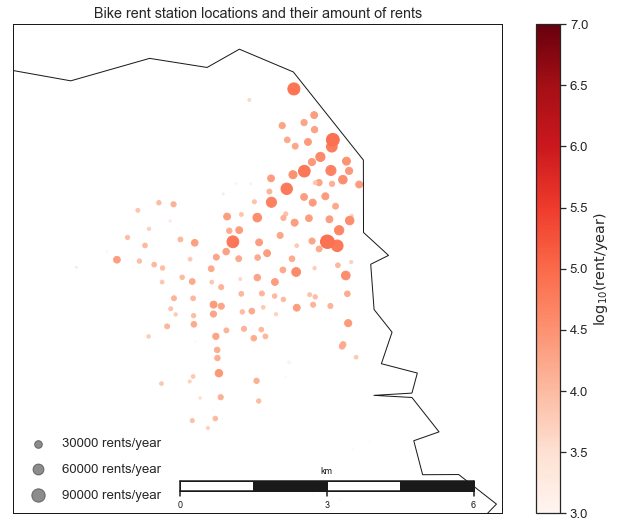

In [178]:
# draw map for first cluster center
center = C[1]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 9))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in East Bay

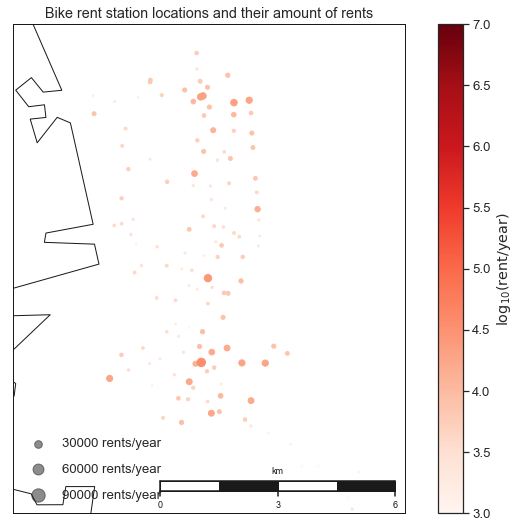

In [179]:
# draw map for first cluster center
center = C[2]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 9))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.0125E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.02, lat=center[0]-0.05, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in San Jos√©

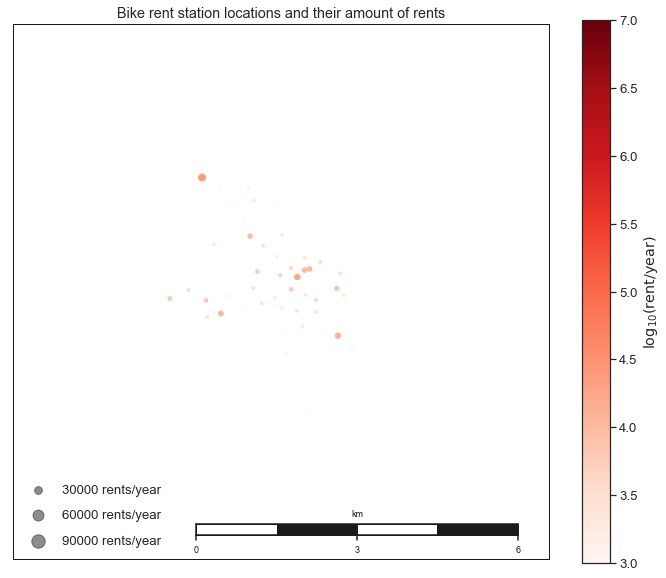

In [180]:
# draw map for first cluster center
center = C[0]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In [181]:
clustered_stations['cluster_id'].value_counts()

San_Francisco    160
East_Bay         145
San_Jose          53
Name: cluster_id, dtype: int64

In [182]:
list(clustered_stations)

['latitude', 'longitude', 'cluster_id']

In [183]:
clustered_stations['cluster_id'].isnull().sum()

0

#### New feature: cluster id in rent table

Add the feature `cluster_id` into the **rent dataframe**. Therefor a sample of the rent dataframe is used. Otherwise iteration over all rows takes too much computation time (with 1863721 rows). A subset of size 10000 is used.

In [184]:
copy_of_member_and_rent = rent_clean.copy()
copy_of_member_and_rent['member_gender'] = member_clean['member_gender']
copy_of_member_and_rent['age'] = member_clean['age']
copy_of_member_and_rent['user_type'] = member_clean['user_type']

rent_sample = copy_of_member_and_rent.sample(10000)

In [185]:
# bring station id into temp clustered_stations dataframe
clustered_stations['id'] = -1

for i, row in clustered_stations.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    lat_temp = row['latitude']
    long_temp = row['longitude']
    frame = station_clean.query('latitude == @lat_temp')
    frame = station_clean.query('longitude == @long_temp')
    
    station_id = frame['id'].iloc[0]
    # write to short rent table
    clustered_stations.loc[i, 'id'] = station_id
    

In [186]:
# bring cluster id into rent_clean dataframe
rent_sample['cluster_id'] = -1

for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'cluster_id'] = cluster_id
    

In [187]:
rent_sample['start_station_id'].nunique()

316

In [188]:
rent_sample['end_station_id'].nunique()

316

 321 of 358 stations are contained in the dataset. Thus, sample data the stations are still well enough distributed over all 3 cities.

Write amount also into stations dataframe.

In [189]:
(station_clean.index == clustered_stations.index).sum()

358

The ids from clustered_stations and station_clean are not the same. So we need to iterate through both using the station id to copy the cluster_ids to the station_clean dataframe. 

In [190]:
station_clean['cluster_name'] = ''
for i, row in station_clean.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    station_clean.loc[i, 'cluster_name'] = cluster_id

In [191]:
station_clean['cluster_name'].isnull().sum()

0

In [192]:
station_clean['cluster_name'].unique()

array(['San_Francisco', 'San_Jose', 'East_Bay'], dtype=object)

In [193]:
station_clean['amount'] = rush_stations['amount']
# and replace cluster ids with names
station_clean['cluster_id'] = station_clean['cluster_name'].replace({'San_Jose': 0, 'San_Francisco': 1, 'East_Bay': 2})

In [194]:
list(station_clean)

['id', 'latitude', 'longitude', 'name', 'cluster_id', 'cluster_name', 'amount']

Now let's have a look back to question 1.

## Question 1:  Are there more busier rent stations than others?

We can now allocate the stations to one of the 3 cities. In which city are the most busiest stations located?

In [195]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

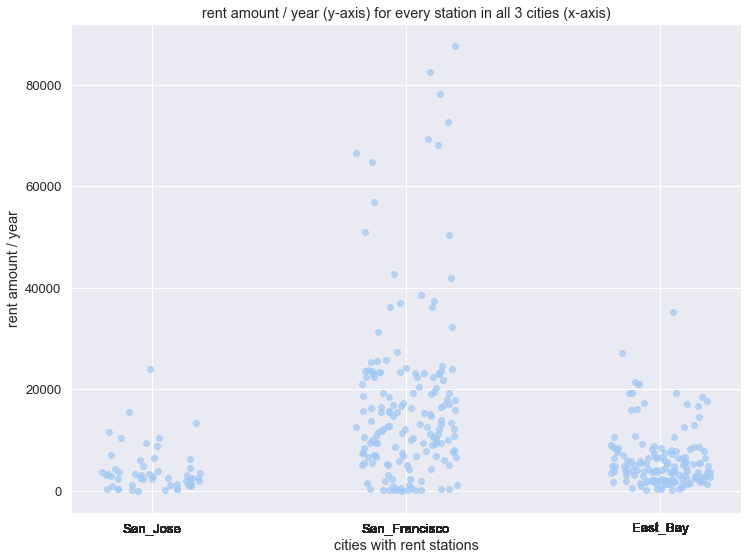

In [196]:
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.regplot( x = station_clean['cluster_id'], y = station_clean['amount'],
            x_jitter = 0.2, scatter_kws={"alpha":0.7}, fit_reg=False);
ax.set_xlabel('cities with rent stations')
ax.set_ylabel('rent amount / year')
ax.set_xticks(station_clean['cluster_id'])
ax.set_xticklabels(station_clean['cluster_name'])

ax.set_title('rent amount / year (y-axis) for every station in all 3 cities (x-axis)');

In the above plot we can see every station related to a cluster (city) and its rent amount / year (y-axis). We can see, that San Francisco has the most busiest stations. Now we want to create a new feature. A busy-feature, by splitting the y-axis values into 3 categories.

In [197]:
# new feature to distinguish between 3 busy stages
station_clean['busy'] = 0
# assign data two two groups of business (depending on amount)
where_above_upper_threshold = station_clean['amount'] > 60000 
where_underneith_upper_threshold = station_clean['amount'] <= 60000 
where_above_lower_threshold = station_clean['amount'] > 20000  

station_clean.loc[where_above_upper_threshold,'busy'] = 2
station_clean.loc[where_underneith_upper_threshold & where_above_lower_threshold,'busy'] = 1

list(station_clean)

['id',
 'latitude',
 'longitude',
 'name',
 'cluster_id',
 'cluster_name',
 'amount',
 'busy']

In [198]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

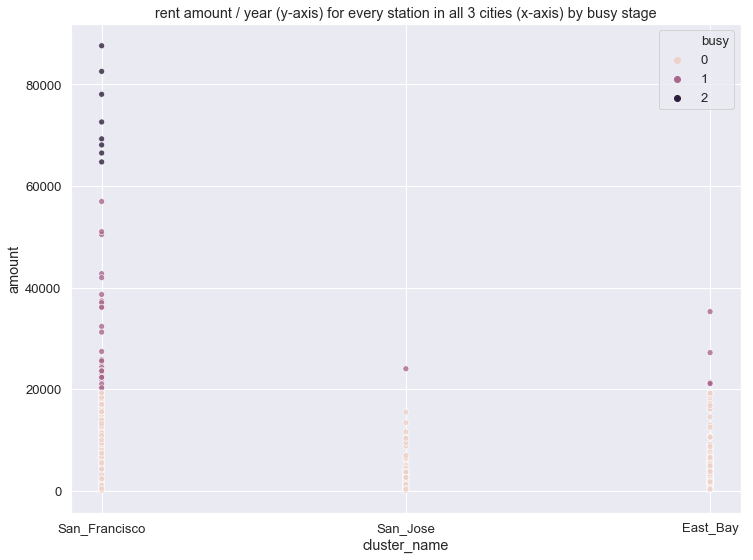

In [199]:
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax = sns.scatterplot(x="cluster_name", y="amount",x_jitter = True,
                      hue="busy", alpha=.8, 
                      data=station_clean)
ax.set_title("rent amount / year (y-axis) for every station in all 3 cities (x-axis) by busy stage");

In which city are the most busiest stations located?

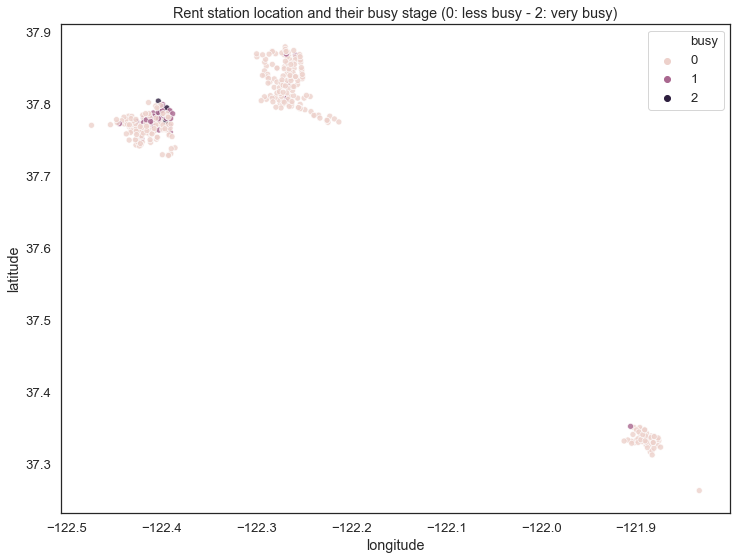

In [200]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="busy", alpha=.8,
                      data=station_clean);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their busy stage (0: less busy - 2: very busy)");

Yes, as was expected the most busiest stations are in San Francisco.

Bring the new feature `busy` to the rent dataframe (using only the start rent staion id to combine for simplicity reasons).

In [201]:
# bring cluster id into rent_clean dataframe
rent_sample['busy'] = -1

for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = station_clean.query('id == @station_id')
    busy_value = frame['busy'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'busy'] = busy_value

### Question 3: Are there different kind of users in different cities?

Do the users in the different cities are different in their distribution of age or gender?



In [202]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

#### User's gender in each city

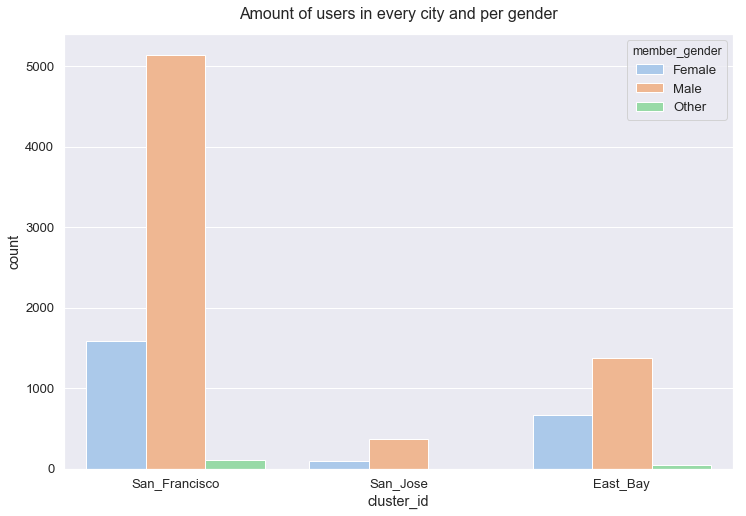

In [203]:
fig.set_size_inches(12, 9)
ax1 = sns.countplot(data = rent_sample, x = 'cluster_id', hue = 'member_gender');
ax1.set_title("Amount of users in every city and per gender", y=1.02,fontsize=16);

In the above plot we can see the count of users (every rent counts as one individual user) per city (x-axis) and per gender (colors).

In San Francisco only 1/4 of the users are female and more than 3/4 are male. In East Bay almost 1/3 of the users are female and 2/3 are male. In San Jose a little bit more than 1/4 are female and less than 3/4 are male users.

In [204]:
rent_sample.groupby('cluster_id')['member_gender'].value_counts()

cluster_id     member_gender
East_Bay       Male             1378
               Female            666
               Other              47
San_Francisco  Male             5147
               Female           1584
               Other             110
San_Jose       Male              371
               Female             95
Name: member_gender, dtype: int64

#### Average age of users per gender

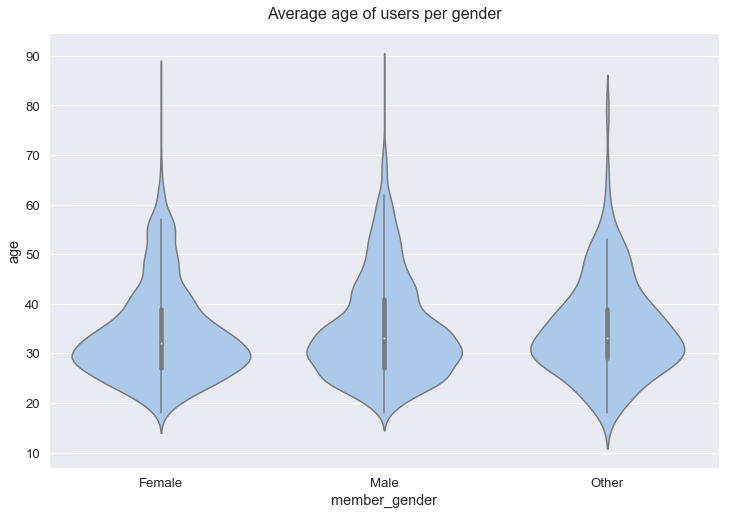

In [205]:
fig.set_size_inches(12, 9)
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'member_gender', y = 'age', color = base_color)
ax1.set_title("Average age of users per gender", y=1.02,fontsize=16);

In the above plot we can see, that the average age of female users is 33.7 and of male users is 35.3 years old.

In [206]:
rent_sample.groupby('member_gender')['age'].mean()

member_gender
Female    34.050000
Male      35.104064
Other     35.105263
Name: age, dtype: float64

In [207]:
rent_sample.groupby('user_type')['age'].mean()

user_type
Customer      33.598404
Subscriber    35.011025
Name: age, dtype: float64

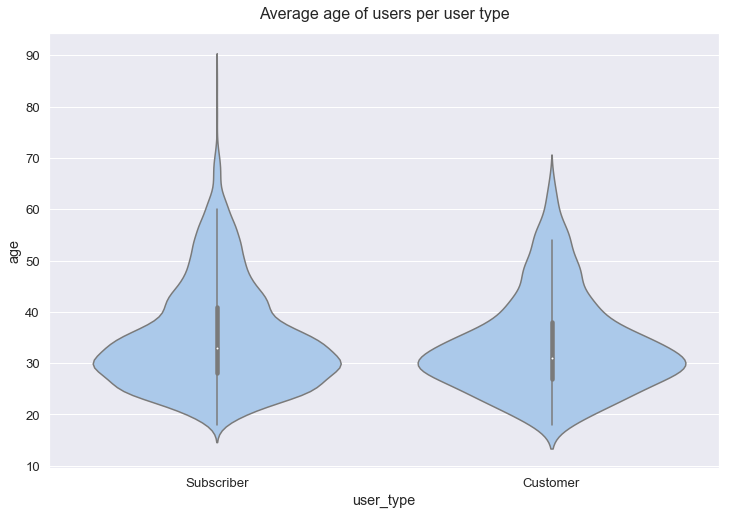

In [208]:
fig.set_size_inches(12, 9)
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'user_type', y = 'age', color = base_color)
ax1.set_title("Average age of users per user type", y=1.02,fontsize=16);

In the above plot we can see, that the age of subscribers are more distributed than of customers (Maximum age is over 90 for subscriber and about 75 for customers). Also the average is younger for customer users with about 32 vs. 35 years for subsriber users.

#### Average age of users per city

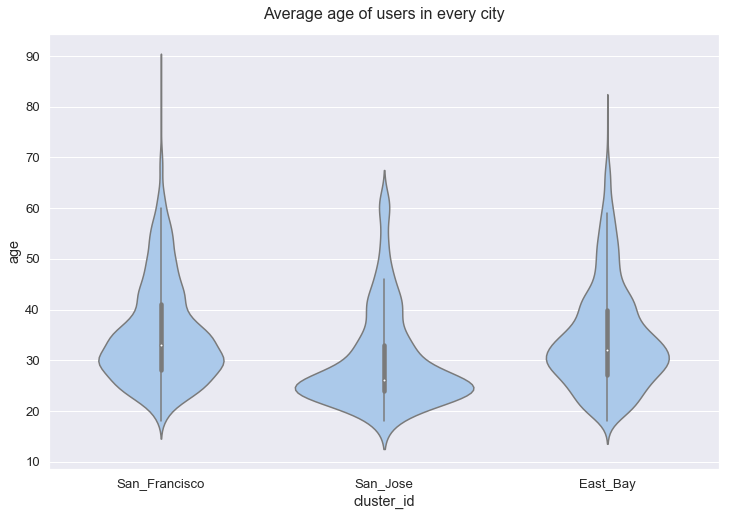

In [209]:
fig.set_size_inches(12, 9)

# left plot: violin plot
#plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = rent_sample, x = 'cluster_id', y = 'age', color = base_color)
ax1.set_title("Average age of users in every city", y=1.02,fontsize=16);

More interesting is the average age of the different cities. In San Francisco the user age's average is over 35, in East Bay about 34 and in San Jose the average age is 30 and less distributed over all ages.

In [210]:
rent_sample.groupby('cluster_id')['age'].mean()

cluster_id
East_Bay         34.448011
San_Francisco    35.298287
San_Jose         29.903433
Name: age, dtype: float64

In [211]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

#### Distribution of user's age per gender and city

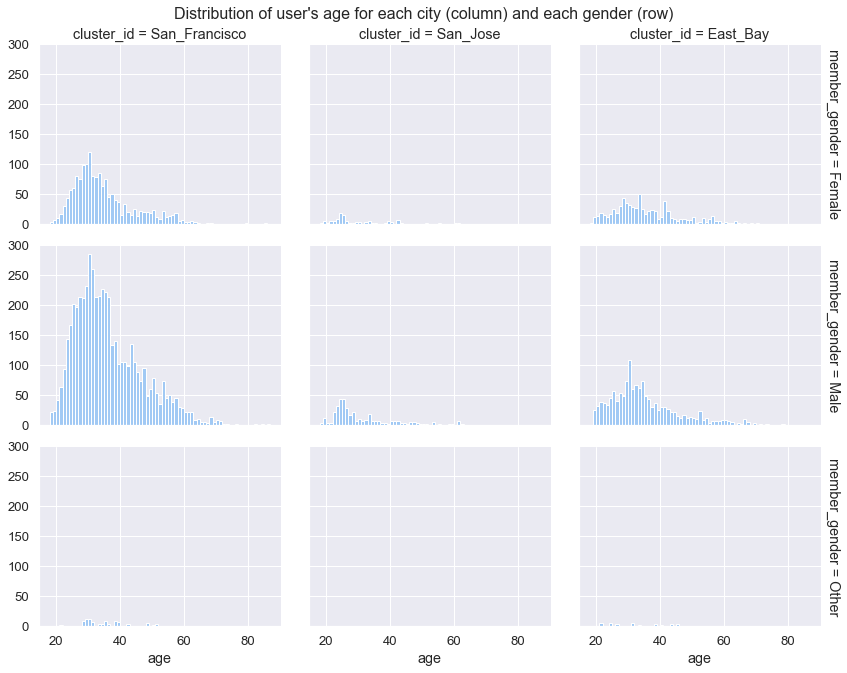

In [212]:
#fig, ax = fig, ax = plt.subplots()

bins = np.arange(rent_sample['age'].min(), rent_sample['age'].max()+1, 1);

g = sns.FacetGrid(data = rent_sample, col = 'cluster_id', row = 'member_gender', height = 4,
                margin_titles = True);
g.map(plt.hist, 'age', bins = bins);
g.fig.set_size_inches(12, 9)
g.fig.suptitle("Distribution of user's age for each city (column) and each gender (row)", y=1.02,fontsize=16);

In this plot, we can see the distribution of user's age for every gender (rows) in every city (columns). Beside that, we can see that San Francisco has the most users and San Jose the fewest.

### Summary

The insights showed, that there are 3 cities, where the rent service is provided and where rent stations are located.

Also, we could confirm that there are more busy rent stations and less busy rent stations. We categorized 3 different business levels to make further investigations on that. And plotted the locations with the amount of rents (businest factor). The busiest stations are located in San Francisco.

With a clustering of the rent station locations, we could provide the city labels for each station and rent data entry. With that label, we did investigate an analysis on user's age and gender in the different cities.



### Suprising results?

In San Francisco and San Jose only 1/5 of the users are female. Whereas in East Bay about 1/3 are female. So, most users are male in every city.

The average age of the users are the lowest in San Jose with 30 years. Whereas in East Bay and San Francisco the users are in average about 34 and 45 years old.

The most users are allocated in San Francisco (not suprising).